# Feature Engineering with information available at initial quote request

- The goal of this notebook is to engineer features from variables of dataset that have been obtained by an underwriter(s) at the first contact (initial insurance quote request).These features can be used for risk classification or technical premium calculation. The variables that we will be working with include:
    - `ID`: Unique identifier for each policyholder
    - `Distribution_channel`: Classifies the channel through which the policy was contracted. 0 for Agent and 1 for Insurance brokers.
    - `Date_birth`: Date of birth of the insured declared in the policy (DD/MM/YYYY)
    - `Date_driving_licence`: Date of issuance of the insured person's driver's license (DD/MM/YYYY)
    - `Premium`: Net premium amount associated with the policy during the current year
    - `Type_risk`: Type of risk associated with the policy. Each value corresponds to a specific risk type: 1 for motorbikes, 2 for vans, 3 for passenger cars and 4 for agricultural vehicles
    - `Area`: Dichotomous variable indicates the area. 0 for rural and 1 for urban (more than 30,000 inhabitants) in terms of traffic conditions.
    - `Second_driver`: 1 if there are multiple regular drivers declared, or 0 if only one driver is declared
    - `Year_matriculation`: Year of registration of the vehicle (YYYY)
    - `Power`: Vehicle power measured in horsepower
    - `Cylinder_capacity`: Cylinder capacity of the vehicle
    - `Value_vehicle`: Market value of the vehicle on 31/12/2019
    - `N_doors`: Number of vehicle doors
    - `Type_fuel`: Specific kind of energy source used to power a vehicle. Petrol (P) or Diesel (D)
    - `Length`: Length, in meters, of the vehicle
    - `Weight`: Weight, in kilograms, of the vehicle


## 001: Create the dataset and split dataset

In [ ]:
import pandas as pd
from src.model.dataset import Dataset

insurance_initiation_variables_path = "../data/input/exp/Insurance_Initiation_Variables.csv"
claims_variables_path = "../data/input/exp/sample_type_claim.csv"

claim_grouping_columns = ['ID', 'Cost_claims_year']
claim_aggregation_column = 'Cost_claims_by_type'
merging_columns = ['ID', 'Cost_claims_year']

dataset =  (Dataset(data_path=insurance_initiation_variables_path,
                              claims_path=claims_variables_path)
                      .group_claims(grouping_columns=claim_grouping_columns,aggregation_column=claim_aggregation_column)
                      .create_dataset(merge_columns=merging_columns)
                     )
trainset, testset = dataset.split_dataset(test_ratio=0.2, to_shuffle=False)

## 002: Research and engineer baseline relevant features

While there are now advancement in the motor insurance sector that enables using telematic data points, I will be exploring traditional features in this segment mostly based on domain knowledge [some capture here](https://www.researchgate.net/publication/338007809_An_Analysis_of_the_Risk_Factors_Determining_Motor_Insurance_Premium_in_a_Small_Island_State_The_Case_of_Malta). Some key ones that align with this dataset include

- Type of Vehicle: `Exists in the dataset`
- Value of the vehicle : `Exists in the dataset`
- Age of the driver : `To be Engineered`
- Vehicle technology equipment : `To be Engineered (easy proxy could be age of vehicle to imply that newer vehicles have more sophisticated technology)`
- Geographic location  : `Exist in the dataset`
- Repair cost of the vehicle: `Close proxy is the value of the vehicle`
- Occupation of the driver: `Not captured in dataset`
- Medical condition of the driver: `Not captured in dataset`
- Recent performance vehicle modifications (power-to-weight ratio, brake horsepower, etc.) : `To be Engineered`

## 003: Implement baseline features tagged `To Be Engineered`

In [3]:
from datetime import datetime
from typing import Any
import numpy as np

def convert_to_datetime(value:object, format:str="%d/%m/%Y", yearfirst:bool=True) -> Any:
    return pd.to_datetime(arg=value, format=format, yearfirst=yearfirst)

def take_datetime_difference_in_years(first_datetime:datetime, second_datetime:datetime, interval) -> float:
    diff = (second_datetime - first_datetime) / np.timedelta64(1, interval)
    diff_years = diff/365.25
    return diff_years

def take_int_difference(first_number:int, second_number:int) -> int:
    return abs(first_number - second_number)

In [4]:
today_date = pd.Timestamp.today()
today_year = today_date.year
features_trainset = (
    trainset
    .assign(
        Date_birth_dt=trainset['Date_birth'].apply(convert_to_datetime),
        Date_driving_licence_dt=trainset['Date_driving_licence'].apply(convert_to_datetime),
        power_to_weight = trainset['Power'] / trainset['Weight'],
        Car_age_years= trainset['Year_matriculation'].apply(take_int_difference, args=(today_year,))

    )
    .assign(
        Driver_age_years=lambda df: df['Date_birth_dt'].apply(take_datetime_difference_in_years, args=(today_date, 'D')),
        Driver_experience_years=lambda df: df['Date_driving_licence_dt'].apply(take_datetime_difference_in_years, args=(today_date, 'D')),
    )
)

At the end of engineering on the features on the trainset, we now have the following variables in our dataset
- ID
- Date_birth
- Date_driving_licence
- Distribution_channel
- Premium
- Cost_claims_year
- Type_risk
- Area
- Second_driver
- Year_matriculation
- Power
- Cylinder_capacity
- Value_vehicle
- N_doors
- Type_fuel
- Length
- Weight
- claims_frequency
- Date_birth_dt
- Date_driving_licence_dt
- power_to_weight
- Car_age_years
- Driver_age_years
- Driver_experience_years
For all intent and purposes, the premium, cost_claims_year and claims frequency are potential target variables



## 04: Exploring engineered features

In [11]:
#Feature completeness pattern
features_trainset.isnull().sum()

ID                             0
Date_birth                     0
Date_driving_licence           0
Distribution_channel           0
Premium                        0
Cost_claims_year               0
Type_risk                      0
Area                           0
Second_driver                  0
Year_matriculation             0
Power                          0
Cylinder_capacity              0
Value_vehicle                  0
N_doors                        0
Type_fuel                   1567
Length                      8846
Weight                         0
claims_frequency           80332
Date_birth_dt                  0
Date_driving_licence_dt        0
power_to_weight                0
Car_age_years                  0
Driver_age_years               0
Driver_experience_years        0
dtype: int64

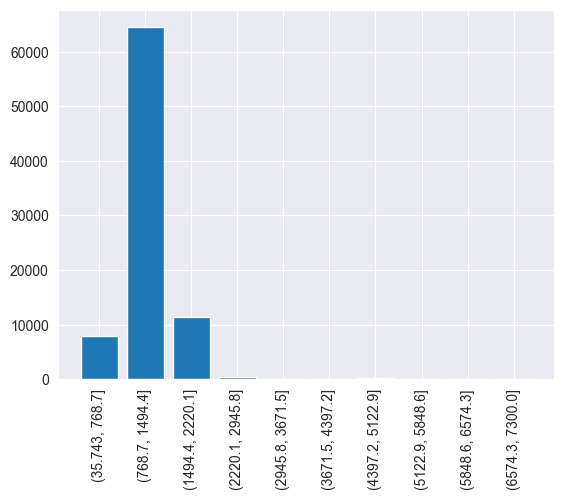

In [25]:
##Feature data distribution pattern - binning pattern for histogram
import matplotlib.pyplot as plt


#Step 1: Bin the variable
variable = 'Weight'
binned_variable = pd.cut(features_trainset[variable], bins=10)

#Step 2: join the binned variable to existing dataset
binned_variable.name = f"binned_{variable}"
binned_df = pd.concat([features_trainset, binned_variable], axis=1 )
#binned_df

#Step 3: Group the dataset using the binned variable
groups = []
for group, subset in features_trainset.groupby(by=binned_variable, observed=False):
    groups.append({
        'Binrange': group,
        'Count': len(subset),
    })
group_df = pd.DataFrame(groups)

#Step 4: Visualise this with histogram using barplot (converted the bin range to str because matplotlib not handling intervals well)
plt.bar(x=group_df['Binrange'].astype(str), height=group_df['Count'])
plt.xticks(rotation=90)
plt.show()

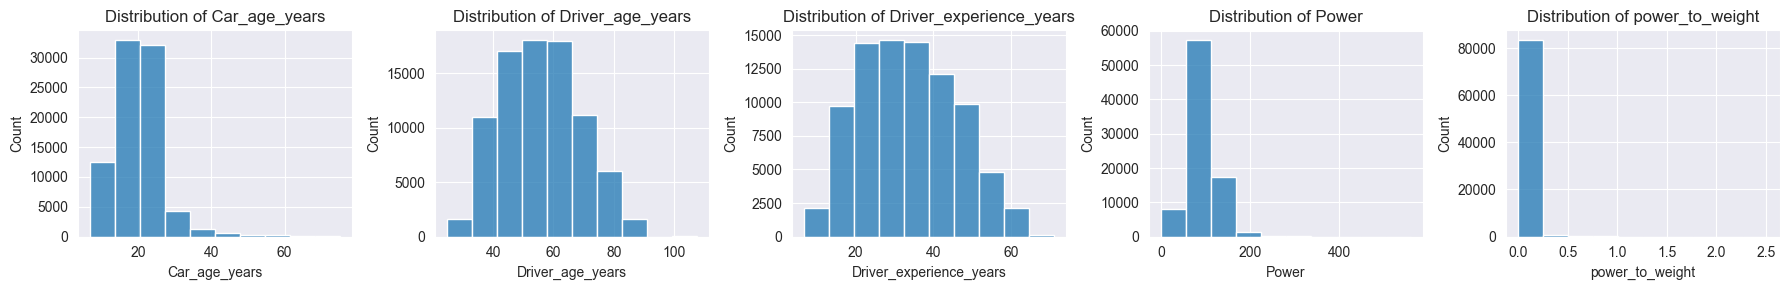

In [33]:
## Easier patter for histogram visualisation with seaborn that scales to columns
import seaborn as sns
import matplotlib.pyplot as plt

#Step 1: Define the columns to obtain distribution as list
cols = ['Car_age_years', 'Driver_age_years', 'Driver_experience_years', 'Power', 'power_to_weight']

##Step 2: Define the bin (in this case number of bins)
bin = 10

#Step 3 : visualise
fig, axes = plt.subplots(1, len(cols), figsize=(18, 3))
for i, col in enumerate(cols):
    sns.histplot(data=features_trainset, x=col, bins=bin, kde=False, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

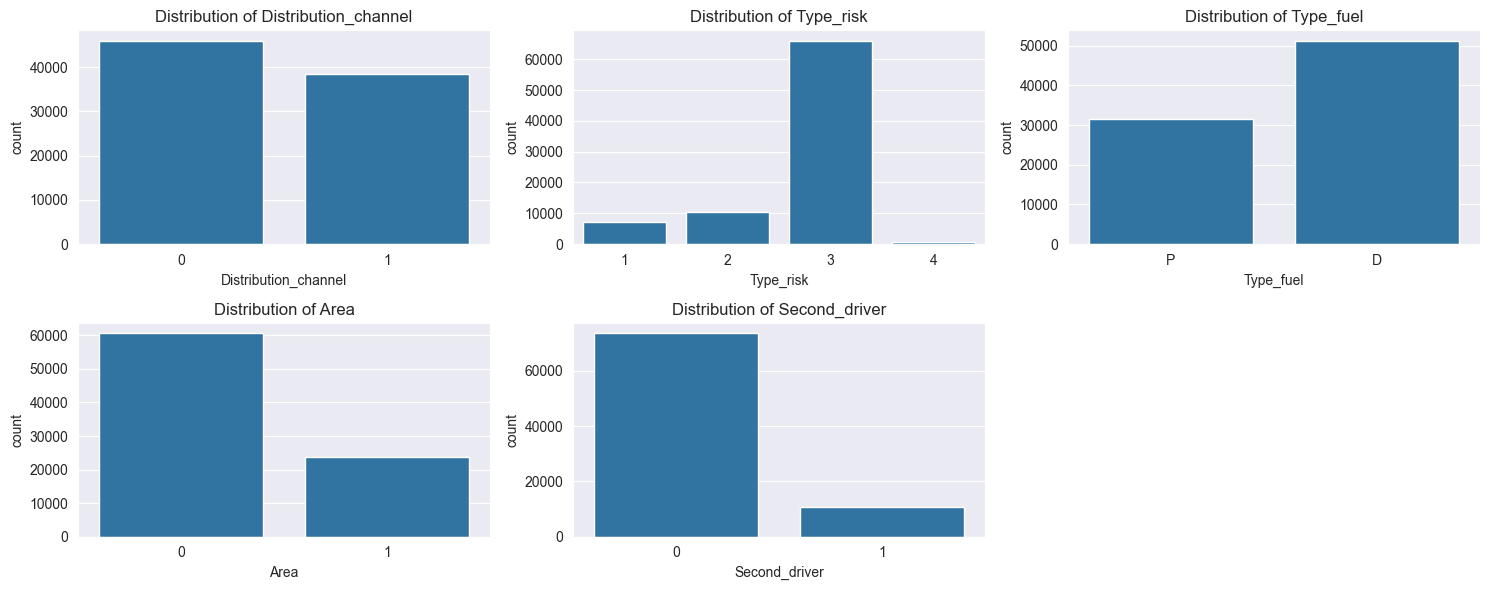

In [35]:
##Similar pattern this time for barplots
cols  = [
    'Distribution_channel',
    'Type_risk',
    'Type_fuel',
    'Area',
    'Second_driver'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns
axes = axes.flatten()  # turn into 1D array

for i, col in enumerate(cols):
    sns.countplot(data=features_trainset, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis="x")
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [47]:
## Simple bivariate relationship pattern
features_trainset[['Power', 'Cylinder_capacity', 'power_to_weight', 'Value_vehicle', 'Length', 'Weight',]].corr()

,Power,Cylinder_capacity,power_to_weight,Value_vehicle,Length,Weight
Power,1.000000,0.657945,0.231210,0.766268,0.469342,0.604842
Cylinder_capacity,0.657945,1.000000,-0.148821,0.751224,0.633133,0.889948
power_to_weight,0.231210,-0.148821,1.000000,-0.025544,-0.076899,-0.238816
Value_vehicle,0.766268,0.751224,-0.025544,1.000000,0.610380,0.748356
Length,0.469342,0.633133,-0.076899,0.610380,1.000000,0.829001
Weight,0.604842,0.889948,-0.238816,0.748356,0.829001,1.000000
